# Oxford: Smooth fit to log-odds ratios

In [1]:
import tqdm 
import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Données

In [2]:
import json 

with open("data/data.json") as file:
    data = json.load(file)
    
with open("data/init.json") as file:
    init = json.load(file)
    
with open("data/params.json") as file:
    params = json.load(file)

In [3]:
for idx, item in data.items():
    data[idx] = np.array(item).reshape(-1)

for idx, item in init.items():
    init[idx] = np.array(item).reshape(-1)

for idx, item in params.items():
    params[idx] = np.array(item).reshape(-1)

In [4]:
data["year2"] = np.power(data["year"], 2) - 22
init["tau"] = init["sigma_sq"]
del init["sigma_sq"]

In [5]:
df = pd.DataFrame(data)

init["mu"][0] = np.mean(df.r0/df.n0)
init["alpha"][0] = np.mean(df.r1/df.n1)

df["r_sum"] = df.r0 + df.r1
df["n_sum"] = df.n0 + df.n1
df["nr_sum_diff"] = df.n_sum - df.r_sum
df["n1r1_diff"] = df.n1 - df.r1

In [6]:
params["tau_a"] = 1e-3
params["tau_b"] = 1e-3

params["var"] = 1e6

## Echantillonneur MCMC

In [7]:
def sampler(nchain, data, init, params):
    
    # initialisation de la chaîne
    # acceptance rates are stored in history
    chain = dict()
    history = dict()
    for param_name, param_init in init.items():
        chain[param_name] = np.zeros((nchain+1, param_init.shape[0]))
        chain[param_name][0, :] = param_init
        
        history[param_name] = np.zeros(param_init.shape[0])
        
    # définition des hyper-paramètres
    K = int(params["K"])
    
    tau_a = params["tau_a"]
    tau_b = params["tau_b"]
    
    var = params["var"]
    
    mu_sd_proposal = params["mu_sd_proposal"]
    alpha_sd_proposal = params["alpha_sd_proposal"]
    beta1_sd_proposal = params["beta1_sd_proposal"]
    beta2_sd_proposal = params["beta2_sd_proposal"]
    b_sd_proposal = params["b_sd_proposal"]
    
    for i in tqdm.tqdm(range(1, nchain+1)):
        ## mise à jour de mu 
        mu_current = chain["mu"][i-1, :]
        alpha_current = chain["alpha"][i-1, :]
        beta1_current = chain["beta1"][i-1, :]
        beta2_current = chain["beta2"][i-1, :]
        b_current = chain["b"][i-1, :]
        
        logpsi_current = alpha_current + beta1_current * data.year + beta2_current*data.year2 + b_current
    
        mu_proposal = mu_current + np.random.normal(scale=mu_sd_proposal, size=K)
        
        mu_top = - mu_proposal / (2*var) - data.nr_sum_diff * mu_proposal
        mu_top = mu_top - data.n0 * np.log1p(np.exp(-mu_proposal))
        mu_top = mu_top - data.n1 * np.log1p(np.exp(-mu_proposal -logpsi_current))
        
        mu_bottom = - mu_current / (2*var) - data.nr_sum_diff * mu_current
        mu_bottom = mu_bottom - data.n0 * np.log1p(np.exp(-mu_current))
        mu_bottom = mu_bottom - data.n1 * np.log1p(np.exp(-mu_current-logpsi_current))
        
        mu_acceptance = np.exp(mu_top - mu_bottom)
        
        mu_accept_mask = (mu_acceptance > np.random.rand(K))
        mu_current[mu_accept_mask] = mu_proposal[mu_accept_mask]
        
        history["mu"] =  history["mu"] + mu_accept_mask
        chain["mu"][i, :] = mu_current
        
        ## mise à jour de alpha
        alpha_proposal = alpha_current + np.random.normal(scale=alpha_sd_proposal)
        logpsi_proposal = logpsi_current + (alpha_proposal - alpha_current)
        
        alpha_top = - np.power(alpha_proposal, 2) / (2*var)
        alpha_top = alpha_top - np.sum(logpsi_proposal * data.n1r1_diff)
        alpha_top = alpha_top - np.sum(data.n1 * np.log1p(np.exp(-mu_current-logpsi_proposal)))
        
        alpha_bottom = - np.power(alpha_current, 2) / (2*var) 
        alpha_bottom = alpha_bottom - np.sum(logpsi_current * data.n1r1_diff)
        alpha_bottom = alpha_bottom - np.sum(data.n1 * np.log1p(np.exp(-mu_current-logpsi_current)))
        
        alpha_acceptance = np.exp(alpha_top - alpha_bottom)
        if alpha_acceptance > np.random.rand():
            chain["alpha"][i, :] = alpha_proposal
            alpha_current = alpha_proposal
            logpsi_current = logpsi_proposal
            history["alpha"] += 1
        else:
            chain["alpha"][i, :] = alpha_current
        
        ## mise à jour de beta1
        beta1_proposal = beta1_current + np.random.normal(scale=beta1_sd_proposal)
        logpsi_proposal = logpsi_current + (beta1_proposal - beta1_current)* data.year
        
        beta1_top = - np.power(beta1_proposal, 2) / (2*var)
        beta1_top = beta1_top - np.sum(logpsi_proposal * data.n1r1_diff)
        beta1_top = beta1_top - np.sum(data.n1 * np.log1p(np.exp(-mu_current-logpsi_proposal)))
        
        beta1_bottom = - np.power(beta1_current, 2) / (2*var)
        beta1_bottom = beta1_bottom - np.sum(logpsi_current * data.n1r1_diff)
        beta1_bottom = beta1_bottom - np.sum(data.n1 * np.log1p(np.exp(-mu_current-logpsi_current)))
        
        beta1_acceptance = np.exp(beta1_top - beta1_bottom)
        if beta1_acceptance > np.random.rand():
            chain["beta1"][i, :] = beta1_proposal
            beta1_current = beta1_proposal
            logpsi_current = logpsi_proposal
            history["beta1"] += 1
        else:
            chain["beta1"][i, :] = beta1_current
        
        ## mise à jour de beta2
        beta2_proposal = beta2_current + np.random.normal(scale=beta2_sd_proposal)
        logpsi_proposal = logpsi_current + (beta2_proposal - beta2_current) * data.year2
        
        beta2_top = - np.power(beta2_proposal, 2) / (2*var)
        beta2_top = beta2_top - np.sum(logpsi_proposal * data.n1r1_diff)
        beta2_top = beta2_top - np.sum(data.n1 * np.log1p(np.exp(-mu_current-logpsi_proposal)))
        
        beta2_bottom = - np.power(beta2_current, 2) / (2*var)
        beta2_bottom = beta2_bottom - np.sum(logpsi_current * data.n1r1_diff)
        beta2_bottom = beta2_bottom - np.sum(data.n1 * np.log1p(np.exp(-mu_current-logpsi_current)))
        
        beta2_acceptance = np.exp(beta2_top - beta2_bottom)
        if beta2_acceptance > np.random.rand():
            chain["beta2"][i, :] = beta2_proposal
            beta2_current = beta2_proposal
            logpsi_current = logpsi_proposal
            history["beta2"] += 1
        else:
            chain["beta2"][i, :] = beta2_current
        
        ## mise à jour de tau
        tau_proposal = np.random.gamma(tau_a + K/2, 1/(tau_b+np.sum(np.power(b_current,2))/2))
        chain["tau"][i, :] = tau_proposal
        tau_current = tau_proposal 
        
        ## mise à jour de b
        b_proposal = b_current + np.random.normal(scale=b_sd_proposal, size=K)
        logpsi_proposal = logpsi_current + (b_proposal - b_current)
        
        b_top = - (tau_current / 2) * np.power(b_proposal, 2)
        b_top = b_top - logpsi_proposal * data.n1r1_diff
        b_top = b_top - data.n1 * np.log1p(np.exp(-mu_current-logpsi_proposal))
        
        b_bottom = - (tau_current / 2) * np.power(b_current, 2)
        b_bottom = b_bottom - logpsi_current * data.n1r1_diff
        b_bottom = b_bottom - data.n1 * np.log1p(np.exp(-mu_current-logpsi_current))
        
        b_acceptance = np.exp(b_top - b_bottom)
        b_accept_mask = (b_acceptance > np.random.rand(K))
        b_current[b_accept_mask] = b_proposal[b_accept_mask]
        logpsi_current[b_accept_mask] = logpsi_proposal[b_accept_mask]
        
        history["b"] = history["b"] + b_accept_mask
        chain["b"][i, :] = b_current

        
    for param_name, param_history in history.items():
        history[param_name] = param_history / nchain
    
    return chain, history

### Choix des écart-types pour M.-H.

In [8]:
sd_proposal_grid = [
    (2.0, .15 , .05, .01, .1 * j)
    for j in range(5, 0, -1)    
]

for u in sd_proposal_grid:
    params["mu_sd_proposal"] = u[0]
    params["alpha_sd_proposal"] = u[1]
    params["beta1_sd_proposal"] = u[2]
    params["beta2_sd_proposal"] = u[3]
    params["b_sd_proposal"] = u[4]
    
    _, history = sampler(1000, df, init, params )
    pprint.pprint(history)
    pprint.pprint(u)
    if (.2<=history["alpha"] <=.3) and (.2<=history["beta1"] <=.3) and (.2<=history["beta2"] <=.3) \
    and np.all(np.logical_and(history["mu"] <= .3, history["mu"]>=.2)) \
    and np.all(np.logical_and(history["b"] <= .3, history["b"]>=.2)):
        params["mu_sd_proposal"] = u[0]
        params["alpha_sd_proposal"] = u[1]
        params["beta1_sd_proposal"] = u[2]
        params["beta2_sd_proposal"] = u[3]
        params["b_sd_proposal"] = u[4]
        
        print("Perfect :)")
        break

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.83it/s]


{'alpha': array([0.296]),
 'b': 0      0.068
1      0.075
2      0.092
3      0.073
4      0.080
       ...  
115    0.099
116    0.088
117    0.085
118    0.065
119    0.063
Length: 120, dtype: float64,
 'beta1': array([0.211]),
 'beta2': array([0.212]),
 'mu': 0      0.355
1      0.256
2      0.332
3      0.240
4      0.221
       ...  
115    0.235
116    0.183
117    0.181
118    0.244
119    0.246
Length: 120, dtype: float64,
 'tau': array([0.])}
(2.0, 0.15, 0.05, 0.01, 0.5)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.88it/s]


{'alpha': array([0.301]),
 'b': 0      0.054
1      0.049
2      0.061
3      0.063
4      0.052
       ...  
115    0.055
116    0.062
117    0.068
118    0.077
119    0.049
Length: 120, dtype: float64,
 'beta1': array([0.229]),
 'beta2': array([0.226]),
 'mu': 0      0.340
1      0.247
2      0.320
3      0.232
4      0.211
       ...  
115    0.239
116    0.194
117    0.203
118    0.249
119    0.247
Length: 120, dtype: float64,
 'tau': array([0.])}
(2.0, 0.15, 0.05, 0.01, 0.4)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.91it/s]


{'alpha': array([0.29]),
 'b': 0      0.225
1      0.215
2      0.196
3      0.208
4      0.207
       ...  
115    0.190
116    0.229
117    0.212
118    0.200
119    0.204
Length: 120, dtype: float64,
 'beta1': array([0.221]),
 'beta2': array([0.207]),
 'mu': 0      0.372
1      0.262
2      0.322
3      0.237
4      0.224
       ...  
115    0.234
116    0.195
117    0.219
118    0.256
119    0.243
Length: 120, dtype: float64,
 'tau': array([0.])}
(2.0, 0.15, 0.05, 0.01, 0.30000000000000004)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.30it/s]


{'alpha': array([0.29]),
 'b': 0      0.309
1      0.283
2      0.271
3      0.274
4      0.277
       ...  
115    0.248
116    0.271
117    0.284
118    0.267
119    0.263
Length: 120, dtype: float64,
 'beta1': array([0.216]),
 'beta2': array([0.221]),
 'mu': 0      0.372
1      0.245
2      0.324
3      0.231
4      0.229
       ...  
115    0.222
116    0.204
117    0.193
118    0.259
119    0.233
Length: 120, dtype: float64,
 'tau': array([0.])}
(2.0, 0.15, 0.05, 0.01, 0.2)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.14it/s]

{'alpha': array([0.297]),
 'b': 0      0.468
1      0.479
2      0.462
3      0.481
4      0.459
       ...  
115    0.477
116    0.487
117    0.490
118    0.473
119    0.464
Length: 120, dtype: float64,
 'beta1': array([0.215]),
 'beta2': array([0.207]),
 'mu': 0      0.341
1      0.273
2      0.295
3      0.252
4      0.200
       ...  
115    0.253
116    0.188
117    0.215
118    0.256
119    0.224
Length: 120, dtype: float64,
 'tau': array([0.])}
(2.0, 0.15, 0.05, 0.01, 0.1)


### Génération de la chaîne

In [9]:
params["mu_sd_proposal"] = 2.0
params["alpha_sd_proposal"] = .15
params["beta1_sd_proposal"] = .05
params["beta2_sd_proposal"] = .01
params["b_sd_proposal"] = .4

chain, history = sampler(10000, df, init, params)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:36<00:00, 103.68it/s]


In [10]:
for param_name, param_rate in history.items():
    print(f"Taux d'acceptation pour {param_name}: \n{param_rate}")

Taux d'acceptation pour alpha: 
[0.2787]
Taux d'acceptation pour beta1: 
[0.2153]
Taux d'acceptation pour beta2: 
[0.2062]
Taux d'acceptation pour mu: 
0      0.3590
1      0.2667
2      0.3097
3      0.2310
4      0.2221
        ...  
115    0.2455
116    0.2054
117    0.1892
118    0.2442
119    0.2378
Length: 120, dtype: float64
Taux d'acceptation pour b: 
0      0.2010
1      0.2039
2      0.1976
3      0.2031
4      0.1965
        ...  
115    0.2035
116    0.1992
117    0.1946
118    0.2030
119    0.1979
Length: 120, dtype: float64
Taux d'acceptation pour tau: 
[0.]


### Visualisation des chaînes (partie M.-H.)

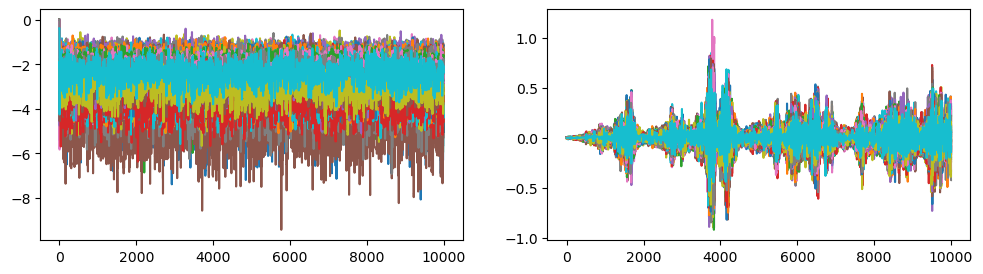

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12,3))
axs[0].plot(chain["mu"])
axs[1].plot(chain["b"])
plt.show()

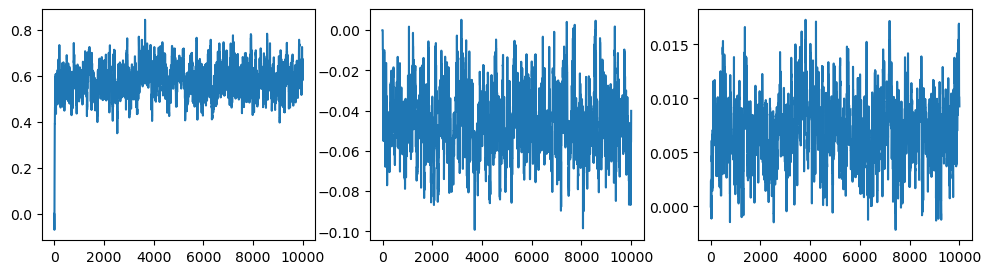

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].plot(chain["alpha"])
axs[1].plot(chain["beta1"])
axs[2].plot(chain["beta2"])
plt.show()

## Lois conditionnelles pleines

### Visualisation

### Estimation ponctuelle

### Intervalles de crédibilité